In [1]:
import pickle
from tqdm import tqdm_notebook, tqdm
import pandas as pd
from rdkit.Chem import AllChem
import numpy as np
from rdkit import Chem
tqdm.pandas()
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
with open('/groups/cherkasvgrp/Student_backup/mkpandey/My_Projects/DDSgroups/Projects/DDS_AL_2M_2_dynamicVAL_mpro_bald_advanced_molformer_False_True/Regression/pred_active_mols_100K_df.pkl','rb') as f:
    pred_active_mols_250K_df = pickle.load(f)

with open('/groups/cherkasvgrp/Student_backup/mkpandey/My_Projects/DDSgroups/Projects/DDS_AL_2M_2_dynamicVAL_mpro_bald_advanced_molformer_False_True/Regression/true_top1pct_df.pkl','rb') as f:
    true_top1pct_df = pickle.load(f)

In [3]:
def generate_morgan_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality = not True, radius=radius, nBits=nBits)
    bit_string = fp.ToBitString()
    return np.array([list(map(int, bit_string))])

In [4]:
pred_active_mols_250K_df['morgan']= pred_active_mols_250K_df.smiles_x.progress_apply(lambda x: generate_morgan_fingerprint(x))

100%|██████████| 100000/100000 [00:43<00:00, 2273.88it/s]


In [16]:
pred_active_mols_250K_df

,smiles_x,zinc_id,mpro_dockscores,labels,pred_label,morgan
677402839,C[C@H]1CN(C(=O)CCn2ccnc2)C[C@@H]1Nc1ncnc2c1CCCC2,ZINCqp00000k7vOr,-41.70,True,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
672113497,Cc1ccc(Br)cc1C[S@@](=O)[C@H](C)c1nncn1C,ZINCjy000003qTmg,-18.26,False,1,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
500602140,CC(C)N(C(=O)C[C@@H](C)c1ccncc1)C1CCOCC1,ZINClz0000020vVC,-32.09,False,1,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
547294787,COCCN(CCc1ccncc1)C(=O)Cc1ccc(F)c(Cl)c1,ZINCoB000005aV1R,-36.12,False,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
39774269,Cc1cc(C(=O)N(C)CCN=c2[nH]c3ccccc3o2)[nH]c1C,ZINCnz000003FDm7,-31.03,False,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
638818837,C/C=C(\F)C(=O)N1[C@H]2CC[C@@H]1CN(C(=O)Cc1cncn...,ZINCng00000j51wB,-29.35,False,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
630880293,C[C@H](CNC(=O)c1cccc(O)n1)N(C)C(=O)c1ccno1,ZINCm8000003xkIb,-31.33,False,1,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
351252029,Cc1cc(CO)cc(=NCCc2ccncc2)[nH]1,ZINCip0000025rAH,-35.11,False,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
26712948,Fc1cccc(C[C@@H]2CCCN2Cc2nc(-c3ccncn3)no2)c1F,ZINCqA000000Fr0o,-29.59,False,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [5]:
# Split dataset into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(pred_active_mols_250K_df, test_size=0.2, random_state=42)  # 80% train
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 10% val, 10% test

X_train, X_val, X_test = np.concatenate(train_df.morgan.values), np.concatenate(val_df.morgan.values), np.concatenate(test_df.morgan.values)
y_train, y_val, y_test = train_df.mpro_dockscores.values, val_df.mpro_dockscores.values, test_df.mpro_dockscores.values

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)
test_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

In [6]:
class OverparamMLPTxRegression(nn.Module):
    def __init__(self, dropout_rate=0.1, num_dense_layers=6, num_residual_blocks=10, num_attention_layers=3):
        super(OverparamMLPTxRegression, self).__init__()
        # smiles_model = "ibm/MoLFormer-XL-both-10pct"

        # self.tokenizer = AutoTokenizer.from_pretrained(smiles_model, trust_remote_code=True)
        # self.base_model = AutoModel.from_pretrained(smiles_model, deterministic_eval=True, trust_remote_code=True)

        hidden_dim = 2048 #self.base_model.config.hidden_size
        intermediate_dim = 5 * hidden_dim  # Increased intermediate layer size

        # Multi-layer attention pooling
        self.attention_layers = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(num_attention_layers)
        ])

        # Deep Dense Layers (Overparameterization)
        self.dense_layers = nn.ModuleList([
            nn.Linear(hidden_dim*num_attention_layers + i * hidden_dim, hidden_dim) for i in range(num_dense_layers)
        ])

        concatenated_size = hidden_dim * num_attention_layers + (hidden_dim * num_dense_layers)
        self.project_dense = nn.Linear(concatenated_size, hidden_dim)

        # Multihead Attention Layers (Stacked for overparameterization)
        self.multihead_attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=16, dropout=dropout_rate, batch_first=True)
            for _ in range(num_attention_layers)
        ])

        # Deep Residual Blocks
        self.residual_blocks = nn.Sequential(*[
            self._create_residual_block(hidden_dim, intermediate_dim, dropout_rate)
            for _ in range(num_residual_blocks)
        ])

        # Fully connected overparameterized layers
        self.fc1 = nn.Linear(hidden_dim, intermediate_dim)
        self.norm1 = nn.LayerNorm(intermediate_dim)
        self.fc2 = nn.Linear(intermediate_dim, intermediate_dim // 2)
        self.norm2 = nn.LayerNorm(intermediate_dim // 2)
        self.fc3 = nn.Linear(intermediate_dim // 2, hidden_dim)  # Additional FC layer

        self.dropout = nn.Dropout(p=dropout_rate)
        self.output_layer = nn.Linear(hidden_dim, 1)  # Regression output

    def _create_residual_block(self, input_dim, output_dim, dropout_rate):
        """Creates a deep residual block with overparameterization"""
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.PReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(output_dim, input_dim),
            nn.LayerNorm(input_dim),
            nn.PReLU(),
        )

    def forward(self, x):
        base_outputs = x.unsqueeze(dim=1)
        # base_outputs = self.base_model(input_ids, attention_mask=attention_mask).last_hidden_state

        # Multi-layer attention pooling
        # pooled_output = base_outputs
        pooled_outputs = []
        for i, attn_layer in enumerate(self.attention_layers):
            # print('tryng attn layer base output', base_outputs.shape)
            # print(attn_layer(base_outputs).shape)
            # print(i)
            attention_weights = torch.softmax(attn_layer(base_outputs), dim=1)
            pooled_output = torch.sum(attention_weights * base_outputs, dim=1)
            pooled_outputs.append(pooled_output)
            # print('pooled_output', pooled_output.shape)
        # Concatenate pooled outputs across all attention layers
        pooled_output = torch.cat(pooled_outputs, dim=1)  # Ensures shape consistency

        # Deep dense connections
        dense_out = pooled_output
        # print('dense out shape ',dense_out.shape)
        for dense_layer in self.dense_layers:
            dense_out = torch.cat([dense_out, dense_layer(dense_out)], dim=1)
            # print('dense out ', dense_out.shape)

        dense_out = self.project_dense(dense_out)

        # Stacked Multihead Attention
        attention_out = dense_out.unsqueeze(1)
        for attn_layer in self.multihead_attention_layers:
            attention_out, _ = attn_layer(attention_out, attention_out, attention_out)

        attention_out = attention_out.squeeze(1)

        # Deep Residual Blocks
        x = self.residual_blocks(attention_out)
        # print('x ', x.shape)
        # Overparameterized Fully Connected Layers
        x = self.norm1(torch.relu(self.fc1(x)))
        x = self.norm2(torch.relu(self.fc2(x)))
        x = torch.relu(self.fc3(x))  # Extra FC layer

        x = self.dropout(x)
        regression_output = self.output_layer(x)

        return regression_output.squeeze()

In [ ]:
import copy
def train_mlp_regression(model, train_loader, val_loader, num_epochs=50, lr=1e-4, patience=9):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-8)

    best_val_loss = float("inf")
    early_stop_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, batch_labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        
        avg_val_loss = val_loss
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            early_stop_counter += 1
            print(f"No improvement in validation loss for {early_stop_counter} consecutive epochs.")

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best epoch was {epoch-early_stop_counter+1}.")
            break
        
    model.load_state_dict(best_model_state)
    return model
        
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     torch.save(model.state_dict(), "best_molformer_regression.pt")
        #     print("Best model saved.")



In [ ]:
model = train_mlp_regression(OverparamMLPTxRegression(num_dense_layers=6, dropout_rate=0.5), train_loader, val_loader, lr = 1e-3, patience=9)

Training Epoch 1/50: 100%|██████████| 2500/2500 [02:54<00:00, 14.35it/s]


Epoch 1: Train Loss = 41.4668, Val Loss = 33.8062
New best validation loss: 33.8062


Training Epoch 2/50: 100%|██████████| 2500/2500 [02:55<00:00, 14.25it/s]


Epoch 2: Train Loss = 37.6193, Val Loss = 34.6915
No improvement in validation loss for 1 consecutive epochs.


Training Epoch 3/50: 100%|██████████| 2500/2500 [02:51<00:00, 14.58it/s]


Epoch 3: Train Loss = 37.0131, Val Loss = 34.6588
No improvement in validation loss for 2 consecutive epochs.


Training Epoch 4/50: 100%|██████████| 2500/2500 [02:44<00:00, 15.18it/s]


Epoch 4: Train Loss = 36.6828, Val Loss = 34.0616
No improvement in validation loss for 3 consecutive epochs.


Training Epoch 5/50: 100%|██████████| 2500/2500 [02:44<00:00, 15.20it/s]


Epoch 5: Train Loss = 36.4841, Val Loss = 33.7082
New best validation loss: 33.7082


Training Epoch 6/50: 100%|██████████| 2500/2500 [02:44<00:00, 15.21it/s]


Epoch 6: Train Loss = 36.3379, Val Loss = 33.7035
New best validation loss: 33.7035


Training Epoch 7/50: 100%|██████████| 2500/2500 [02:49<00:00, 14.72it/s]


Epoch 7: Train Loss = 36.3445, Val Loss = 33.9045
No improvement in validation loss for 1 consecutive epochs.


Training Epoch 8/50: 100%|██████████| 2500/2500 [02:51<00:00, 14.56it/s]


Epoch 8: Train Loss = 36.2044, Val Loss = 33.7037
No improvement in validation loss for 2 consecutive epochs.


Training Epoch 9/50: 100%|██████████| 2500/2500 [02:53<00:00, 14.39it/s]


Epoch 9: Train Loss = 36.1552, Val Loss = 33.7054
No improvement in validation loss for 3 consecutive epochs.


Training Epoch 10/50: 100%|██████████| 2500/2500 [02:56<00:00, 14.20it/s]


Epoch 10: Train Loss = 36.2193, Val Loss = 34.3202
No improvement in validation loss for 4 consecutive epochs.


Training Epoch 11/50: 100%|██████████| 2500/2500 [02:54<00:00, 14.35it/s]


Epoch 11: Train Loss = 36.1011, Val Loss = 33.8344
No improvement in validation loss for 5 consecutive epochs.


Training Epoch 12/50: 100%|██████████| 2500/2500 [02:54<00:00, 14.31it/s]


Epoch 12: Train Loss = 36.0513, Val Loss = 35.2582
No improvement in validation loss for 6 consecutive epochs.


Training Epoch 13/50: 100%|██████████| 2500/2500 [02:52<00:00, 14.50it/s]


Epoch 13: Train Loss = 36.0952, Val Loss = 33.7083
No improvement in validation loss for 7 consecutive epochs.


Training Epoch 14/50: 100%|██████████| 2500/2500 [02:54<00:00, 14.34it/s]


Epoch 14: Train Loss = 36.0264, Val Loss = 33.8487
No improvement in validation loss for 8 consecutive epochs.


Training Epoch 15/50: 100%|██████████| 2500/2500 [02:55<00:00, 14.22it/s]


Epoch 15: Train Loss = 35.8601, Val Loss = 33.8603
No improvement in validation loss for 9 consecutive epochs.
Early stopping triggered at epoch 15. Best epoch was 6.


: 

/tmp/ipykernel_1428400/3423844099.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(true_scores, pred_scores)
/tmp/ipykernel_1428400/3423844099.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


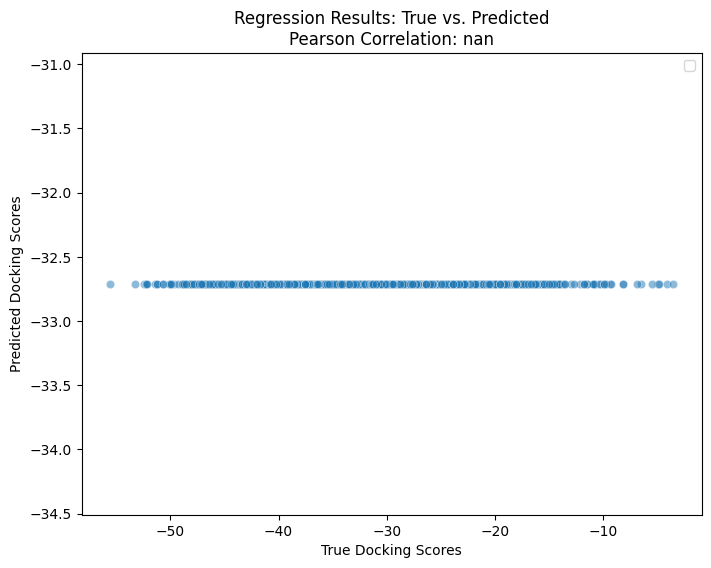

Pearson Correlation Coefficient: nan


In [15]:
from scipy.stats import pearsonr

def plot_predictions(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    true_scores, pred_scores = [], []

    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)

            true_scores.extend(batch_labels.detach().cpu())
            pred_scores.extend(outputs.detach().cpu())

    # Convert to NumPy arrays
    true_scores = np.array(true_scores)
    pred_scores = np.array(pred_scores).flatten()
    pred_scores = np.round(pred_scores, 2)

    # print(true_scores, pred_scores)

    # Compute Pearson correlation coefficient
    correlation, _ = pearsonr(true_scores, pred_scores)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=true_scores, y=pred_scores, alpha=0.5)
    plt.xlabel("True Docking Scores")
    plt.ylabel("Predicted Docking Scores")
    plt.title(f"Regression Results: True vs. Predicted\nPearson Correlation: {correlation:.4f}")
    
    # Draw diagonal line
    min_val = min(true_scores.min(), pred_scores.min())
    max_val = max(true_scores.max(), pred_scores.max())
    # plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Perfect Prediction")

    plt.legend()
    plt.show()

    print(f"Pearson Correlation Coefficient: {correlation:.4f}")

# Call the function after training
plot_predictions(model, val_loader)


In [10]:
batch_labels[0]

tensor(-36.5300)